In [1]:
from gettext import install
import os
import numpy as np 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Paths
train_dir = "C:\\Users\\jyoth\\OneDrive\\Desktop\\train"
val_dir = "C:\\Users\\jyoth\\OneDrive\\Desktop\\test"
img_size = 224
batch_size = 32
num_classes = 12

In [3]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4395 images belonging to 12 classes.
Found 1099 images belonging to 12 classes.


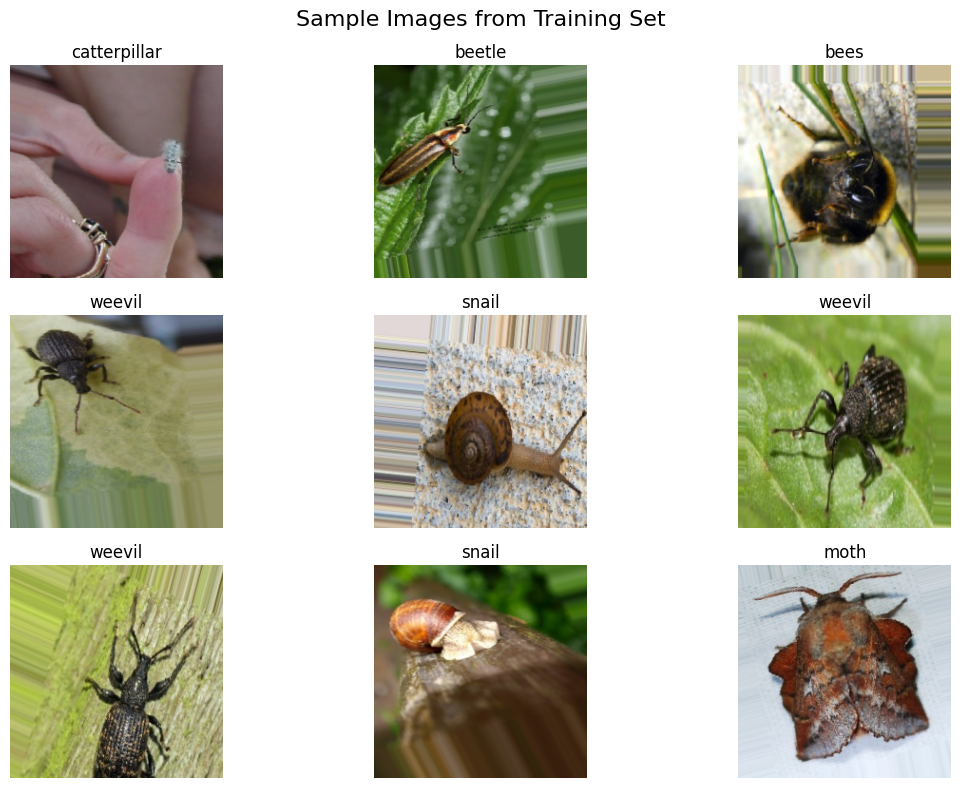

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_data)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    class_index = np.argmax(y_batch[i])
    class_name = list(train_data.class_indices.keys())[class_index]
    plt.title(class_name)
    plt.axis('off')
plt.suptitle("Sample Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()


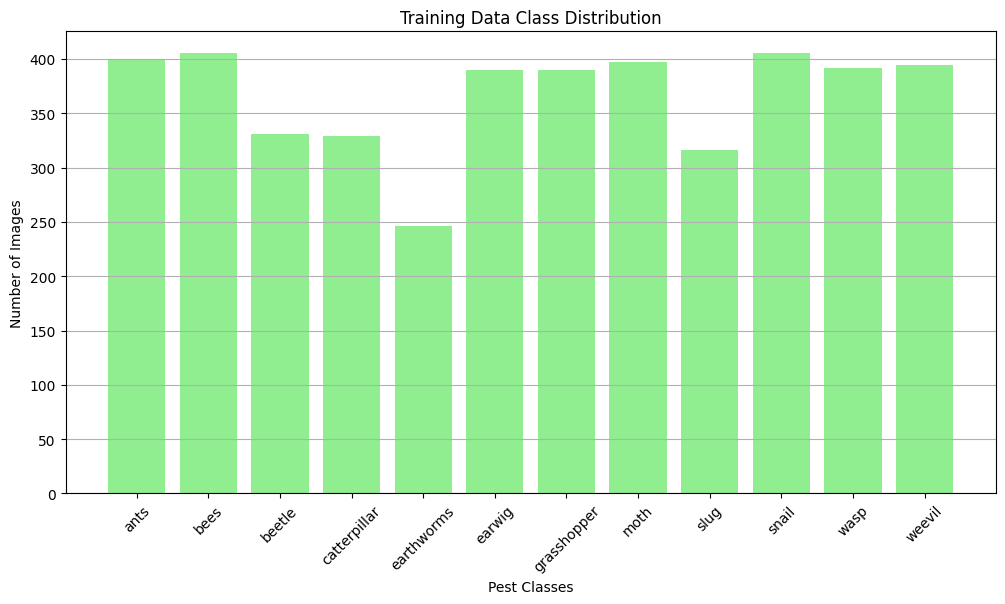

In [7]:
from collections import Counter

counter = Counter(train_data.classes)
labels = list(train_data.class_indices.keys())
counts = [counter[k] for k in range(len(labels))]

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='lightgreen')
plt.xticks(rotation=45)
plt.title("Training Data Class Distribution")
plt.xlabel("Pest Classes")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()


In [8]:

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model initially


In [9]:

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [10]:
# Compile (only training head)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train only the top layers
print("\n🔒 Training custom top layers (frozen base)...\n")

model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Unfreeze the entire base model
print("\n🔓 Unfreezing base model for fine-tuning...\n")

base_model.trainable = True

# Re-compile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune all layers
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)



🔒 Training custom top layers (frozen base)...

Epoch 1/5
138/138 [==============================] - ETA: 0s - loss: 2.5048 - accuracy: 0.0856
Epoch 1: val_accuracy improved from -inf to 0.08644, saving model to best_model.h5


c:\Users\jyoth\pest-detection-ultimate\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 234s 2s/step - loss: 2.5048 - accuracy: 0.0856 - val_loss: 2.4860 - val_accuracy: 0.0864 - lr: 0.0010
Epoch 2/5
138/138 [==============================] - ETA: 0s - loss: 2.4822 - accuracy: 0.0867
Epoch 2: val_accuracy did not improve from 0.08644
138/138 [==============================] - 217s 2s/step - loss: 2.4822 - accuracy: 0.0867 - val_loss: 2.4831 - val_accuracy: 0.0828 - lr: 0.0010
Epoch 3/5
138/138 [==============================] - ETA: 0s - loss: 2.4805 - accuracy: 0.0799
Epoch 3: val_accuracy did not improve from 0.08644
138/138 [==============================] - 221s 2s/step - loss: 2.4805 - accuracy: 0.0799 - val_loss: 2.4827 - val_accuracy: 0.0828 - lr: 0.0010
Epoch 4/5
138/138 [==============================] - ETA: 0s - loss: 2.4785 - accuracy: 0.0849
Epoch 4: val_accuracy improved from 0.08644 to 0.08826, saving model to best_model.h5
138/138 [==============================] - 195s 1s/step - loss: 2.4785 - accuracy: 0.0849 - 

In [11]:
# Load best model weights (optional if not loaded already)
model.load_weights("best_model.h5")

# Evaluate
loss, accuracy = model.evaluate(val_data)
print(f"✅ Final Validation Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Final Validation Loss: {loss:.4f}")


35/35 [==============================] - 47s 1s/step - loss: 0.5135 - accuracy: 0.8544
✅ Final Validation Accuracy: 85.44%
✅ Final Validation Loss: 0.5135


35/35 [==============================] - 45s 1s/step
Classification Report:

              precision    recall  f1-score   support

        ants       0.10      0.11      0.10        99
        bees       0.06      0.06      0.06        95
      beetle       0.10      0.08      0.09        85
catterpillar       0.07      0.07      0.07       105
  earthworms       0.09      0.08      0.08        77
      earwig       0.05      0.04      0.04        76
 grasshopper       0.09      0.11      0.10        95
        moth       0.09      0.09      0.09       100
        slug       0.07      0.08      0.08        75
       snail       0.13      0.14      0.13        95
        wasp       0.11      0.11      0.11       106
      weevil       0.11      0.12      0.11        91

    accuracy                           0.09      1099
   macro avg       0.09      0.09      0.09      1099
weighted avg       0.09      0.09      0.09      1099



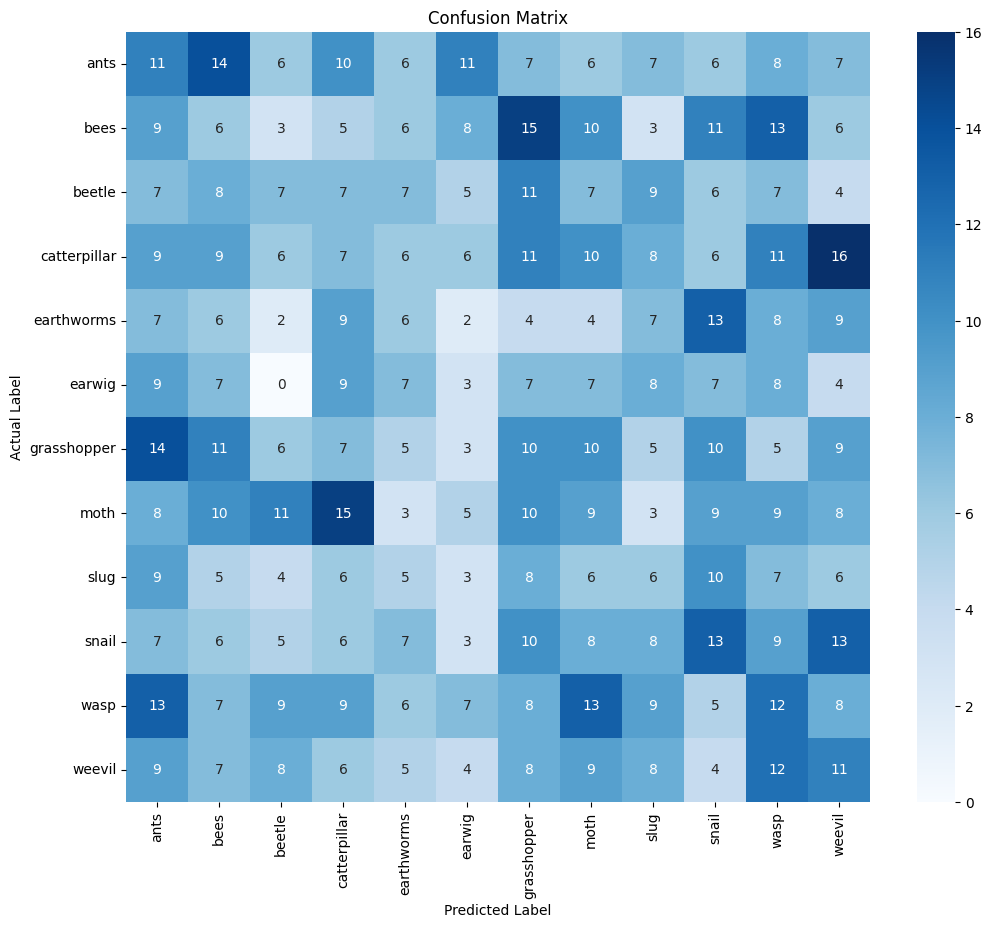

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predict on validation set
val_data.reset()  # Important to avoid batch issues
preds = model.predict(val_data)
y_pred = np.argmax(preds, axis=1)
y_true = val_data.classes

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


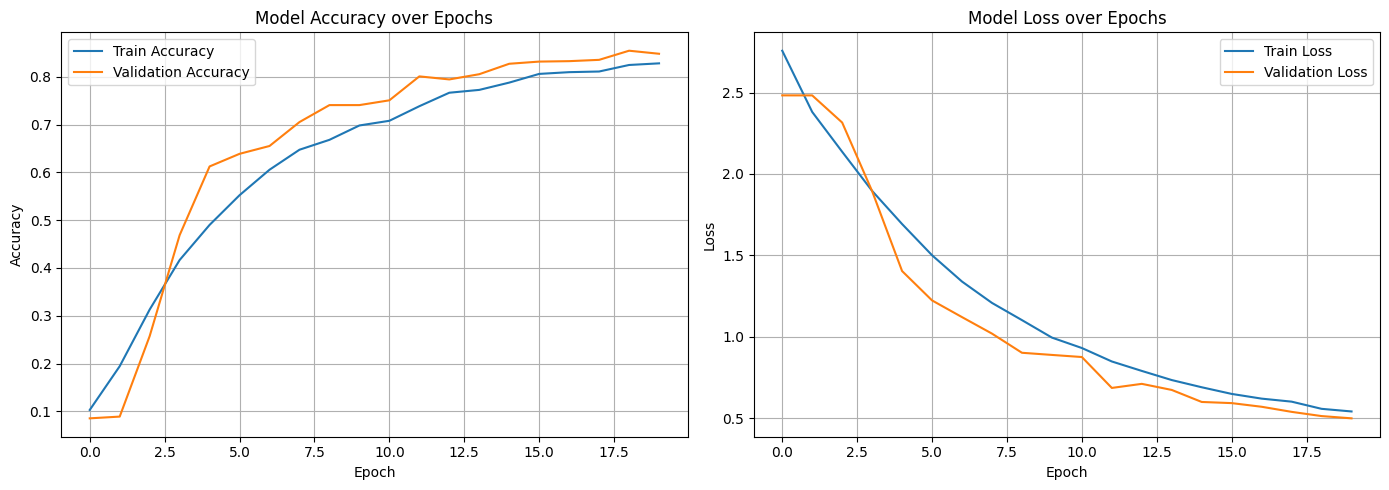

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
plt.figure(figsize=(14, 5))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
# Save the complete model (not just weights)
model.save("final_pest_classifier_model.h5")
print("✅ Full model saved as 'final_pest_classifier_model.h5'")


c:\Users\jyoth\pest-detection-ultimate\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Full model saved as 'final_pest_classifier_model.h5'
